In [ ]:
import numpy as np
def get_condition_indices(stabilizer_shape):
    """
    Extracts the list of relative positions (dx, dy) from a 3x3 binary rule matrix
    that define which neighbor cells contribute to the update rule.

    The (0, *) row is ignored (assumed to represent the current cell),
    and only rows 1 and 2 are used to define condition offsets.
    """
    rows, cols = stabilizer_shape.shape
    relative_positions = [[(0, 0), (0, 0), (0, 0)], # row 0 (ignored because it's result of input)
                   [(1, -1), (1, 0), (1, 1)], # row 1
                   [(2, -1), (2, 0), (2, 1)]] # row 2

    active_conditions = []               

    for i in range(1, rows):
        for j in range(cols):
            if stabilizer_shape[i][j] == 1:
                active_conditions.append(relative_positions[i][j])

    return active_conditions

def fill_Z_with_stabilizer_shape(input_row, H, L, m, condition_offsets_list):
    """Evolve the automaton from the input_row using given rule offsets."""
    Z = np.zeros((H - m + 1, L), dtype=int)
    Z = np.append(Z, input_row, axis=0)  # append input row at the bottom
    for i in range(H - m, -1, -1):  # evolve upward
        condition_offsets = condition_offsets_list[H - m - i]  # get the condition offsets for this row
        for j in range(L):
            neighbor_sum = 0
            for dx, dy in condition_offsets:
                neighbor_sum += Z[i + dx, (j + dy) % L]
            Z[i, j] = 1 if neighbor_sum % 2 == 1 else 0  # parity check

    return Z

def precompute_basis_outputs(H, L, m, condition_indices):
    """Precompute Z for each basis input (single 1 at position i)."""
    Z_basis = []

    for i in range(m-1):
        input_i = np.zeros((1, (m-1) * L), dtype=int)
        input_i = input_i.reshape(m - 1, L)
        input_i[i, 0] = 1
        Z_first = fill_Z_with_stabilizer_shape(input_i, H, L, m, condition_indices)
        Z_basis.append(Z_first)

        for j in range(1, L):
            Z_j = np.roll(Z_first, j, axis=1)
            Z_basis.append(Z_j)

    """Print the precomputed Z_basis for debugging"""
    # print(f"Precomputed Z_basis for H={H}, L={L}, m={m}:")
    # for idx, z in enumerate(Z_basis):
    #     print(f"Z_basis[{idx}] (index {idx}):\n{z}")

    return Z_basis

def evolve_via_basis(input_row, Z_basis, L, min_weight):
    """Use linearity to compute Z for arbitrary input row."""
    result = np.zeros_like(Z_basis[0])
    indices = np.transpose(np.nonzero(input_row))
    for x, y in indices:
        idx = x * L + y  # compute index in Z_basis
        result = np.bitwise_xor(result, Z_basis[idx])
    return result

from itertools import product

def find_distance_via_basis(Z_basis, H, L, m):
    n = H * L
    k = (m - 1) * L
    min_weight = H * L  # initialize large
    kd_over_n = 0

    for bits in product([0, 1], repeat=(m-1) * L):
        input_row = np.array(bits, dtype=int)
        input_row = input_row.reshape(m-1, L)  # reshape for input row
        Z = evolve_via_basis(input_row, Z_basis, L, min_weight)
        weight = np.sum(Z)
        if weight > 0:
            if weight < min_weight:
                # New lower weight found: reset lists
                min_weight = weight
                kd_over_n = (k * min_weight) / n
                min_weight_inputs = [input_row.copy()]
                min_weight_outputs = [Z.copy()]
                print(f"Found Z with d={weight}: \n{Z}")
            elif weight == min_weight:
                # Same as current min_weight: add to list
                min_weight_inputs.append(input_row.copy())
                min_weight_outputs.append(Z.copy())
                print(f"Found Z with d={weight}: \n{Z}")
    print(f"best kd/n = {kd_over_n:.2f}")
    return min_weight_inputs, min_weight_outputs, k, min_weight, n, kd_over_n



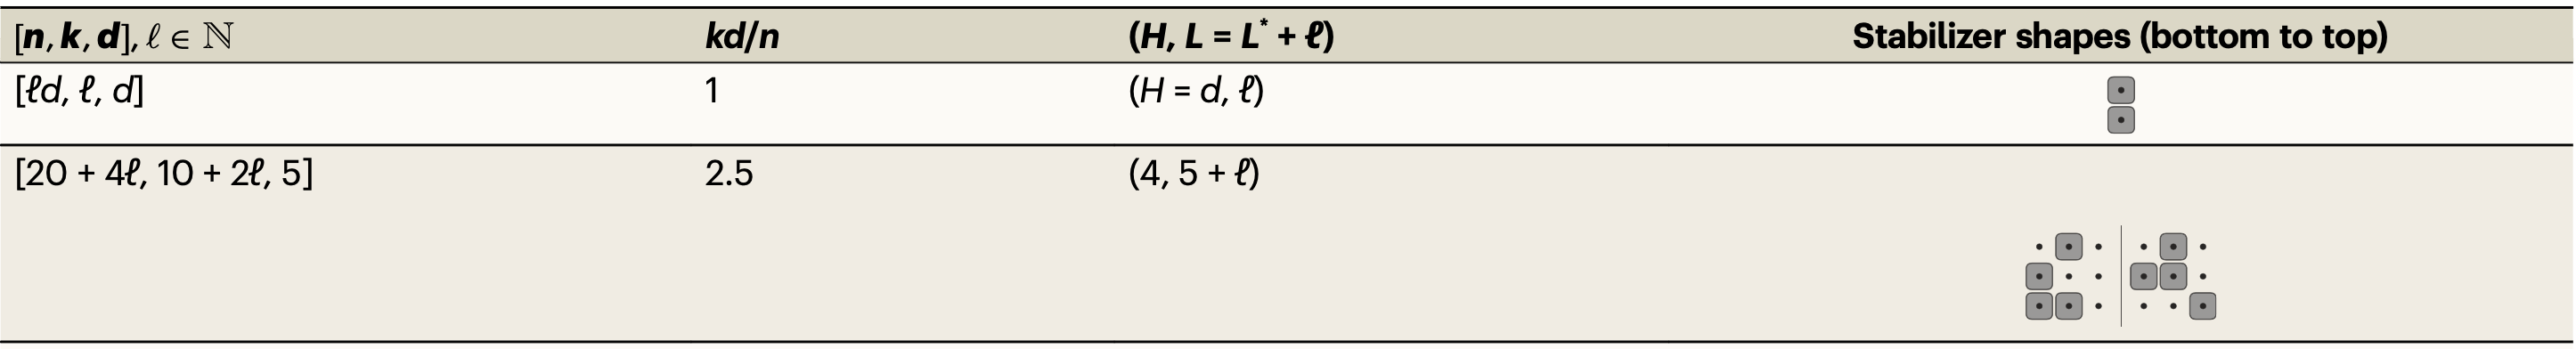

In [16]:
H, L = 4, 5
m = 3
stabilizer_shapes = [
    np.array([[0, 1, 0],
              [1, 0, 0],
              [1, 1, 0]]),
    np.array([[0, 1, 0],
              [1, 1, 0],
              [0, 0, 1]])
]

print("Stabilizer shapes:")
print(stabilizer_shapes)
condition_indices_list = []

for shape in stabilizer_shapes:
    assert shape.shape == (3, 3), "Stabilizer shape must be 3x3."
    condition_indices_list.append(get_condition_indices(shape))

print(f"Condition indices extracted: {condition_indices_list}")

Z_basis = precompute_basis_outputs(H, L, m, condition_indices_list)

min_weight_inputs, min_weight_outputs, k, d, n, kd_over_n = find_distance_via_basis(Z_basis, H, L, m)
print(f"k: {k}, d: {d}, n: {n}, kd/n: {kd_over_n:.2f}")

Stabilizer shapes:
[array([[0, 1, 0],
       [1, 0, 0],
       [1, 1, 0]]), array([[0, 1, 0],
       [1, 1, 0],
       [0, 0, 1]])]
Condition indices extracted: [[(1, -1), (2, -1), (2, 0)], [(1, -1), (1, 0), (2, 1)]]
Found Z with d=5: 
[[0 1 0 0 1]
 [1 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 1]]
Found Z with d=5: 
[[1 0 0 1 0]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 0 1 0]]
Found Z with d=5: 
[[0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]
Found Z with d=5: 
[[0 1 0 1 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]
Found Z with d=5: 
[[1 0 1 0 0]
 [1 1 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]
Found Z with d=5: 
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]]
Found Z with d=5: 
[[1 1 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]
Found Z with d=5: 
[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 1]]
Found Z with d=5: 
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 1 0 0 0]]
Found Z with d=5: 
[[1 0 1 0 1]
 [0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 0]]
Found Z with d=5: 
[[0 0 0 1 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0

In [17]:
for i, (input_row, Z) in enumerate(zip(min_weight_inputs, min_weight_outputs)):
    print(f"Input {i}: \n{input_row}")
    print(f"Z output {i}: \n{Z}")

Input 0: 
[[0 0 0 0 0]
 [0 0 0 0 1]]
Z output 0: 
[[0 1 0 0 1]
 [1 0 0 0 1]
 [0 0 0 0 0]
 [0 0 0 0 1]]
Input 1: 
[[0 0 0 0 0]
 [0 0 0 1 0]]
Z output 1: 
[[1 0 0 1 0]
 [0 0 0 1 1]
 [0 0 0 0 0]
 [0 0 0 1 0]]
Input 2: 
[[0 0 0 0 0]
 [0 0 1 0 0]]
Z output 2: 
[[0 0 1 0 1]
 [0 0 1 1 0]
 [0 0 0 0 0]
 [0 0 1 0 0]]
Input 3: 
[[0 0 0 0 0]
 [0 1 0 0 0]]
Z output 3: 
[[0 1 0 1 0]
 [0 1 1 0 0]
 [0 0 0 0 0]
 [0 1 0 0 0]]
Input 4: 
[[0 0 0 0 0]
 [1 0 0 0 0]]
Z output 4: 
[[1 0 1 0 0]
 [1 1 0 0 0]
 [0 0 0 0 0]
 [1 0 0 0 0]]
Input 5: 
[[0 0 0 0 0]
 [1 1 1 1 1]]
Z output 5: 
[[0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]]
Input 6: 
[[0 0 0 0 1]
 [0 0 0 0 0]]
Z output 6: 
[[1 1 0 1 0]
 [1 0 0 0 0]
 [0 0 0 0 1]
 [0 0 0 0 0]]
Input 7: 
[[0 0 0 0 1]
 [0 0 0 1 1]]
Z output 7: 
[[0 0 0 0 1]
 [0 0 0 1 0]
 [0 0 0 0 1]
 [0 0 0 1 1]]
Input 8: 
[[0 0 0 0 1]
 [1 1 0 0 0]]
Z output 8: 
[[0 0 1 0 0]
 [0 0 1 0 0]
 [0 0 0 0 1]
 [1 1 0 0 0]]
Input 9: 
[[0 0 0 1 0]
 [0 0 0 0 0]]
Z output 9: 
[[1 0 1 0 1]
 [0 0 0 0 

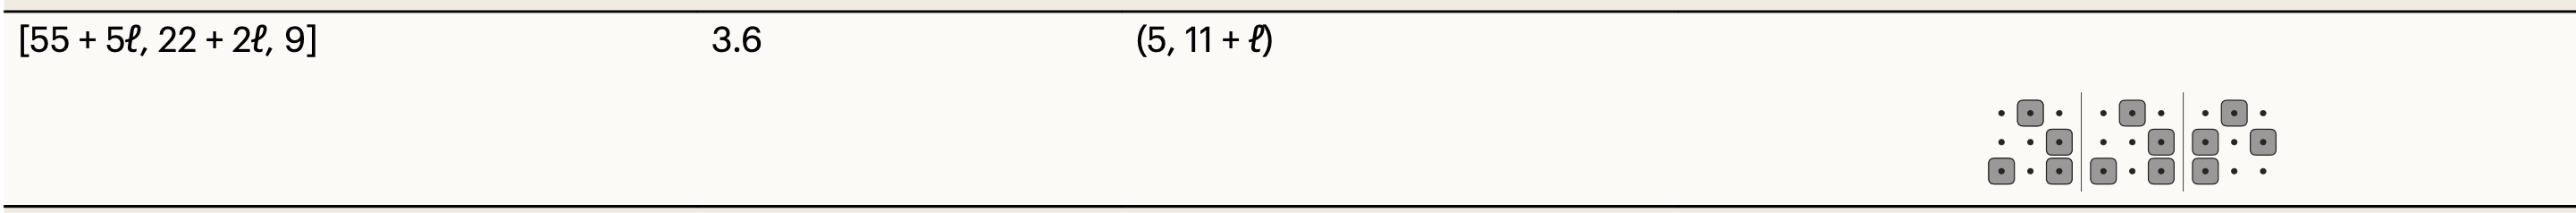

In [18]:
H, L = 5, 11
m = 3
stabilizer_shapes = [
    np.array([[0, 1, 0],
              [0, 0, 1],
              [1, 0, 1]]),
    np.array([[0, 1, 0],
              [0, 0, 1],
              [1, 0, 1]]),
    np.array([[0, 1, 0],
              [1, 0, 1],
              [1, 0, 0]])
]

print("Stabilizer shapes:")
print(stabilizer_shapes)
condition_indices_list = []

for shape in stabilizer_shapes:
    assert shape.shape == (3, 3), "Stabilizer shape must be 3x3."
    condition_indices_list.append(get_condition_indices(shape))

print(f"Condition indices extracted: {condition_indices_list}")

Z_basis = precompute_basis_outputs(H, L, m, condition_indices_list)

min_weight_inputs, min_weight_outputs, k, d, n, kd_over_n = find_distance_via_basis(Z_basis, H, L, m)
print(f"k: {k}, d: {d}, n: {n}, kd/n: {kd_over_n:.2f}")

Stabilizer shapes:
[array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 1]]), array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 1]]), array([[0, 1, 0],
       [1, 0, 1],
       [1, 0, 0]])]
Condition indices extracted: [[(1, 1), (2, -1), (2, 1)], [(1, 1), (2, -1), (2, 1)], [(1, -1), (1, 1), (2, -1)]]
Found Z with d=9: 
[[1 1 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]]
Found Z with d=9: 
[[1 0 0 0 0 0 1 0 0 1 1]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]
Found Z with d=9: 
[[0 0 0 0 0 1 0 0 1 1 1]
 [0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]]
Found Z with d=9: 
[[0 0 0 0 1 0 0 1 1 1 0]
 [0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]]
Found Z with d=9: 
[[0 0 0 1 0 0 1 1 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 

In [6]:
for i, (input_row, Z) in enumerate(zip(min_weight_inputs, min_weight_outputs)):
    print(f"Input {i}: \n{input_row}")
    print(f"Z output {i}: \n{Z}")

Input 0: 
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]]
Z output 0: 
[[1 1 0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 0 0 1 0 1]
 [1 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1]]
Input 1: 
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]
Z output 1: 
[[1 0 0 0 0 0 1 0 0 1 1]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]]
Input 2: 
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]]
Z output 2: 
[[0 0 0 0 0 1 0 0 1 1 1]
 [0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]]
Input 3: 
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]]
Z output 3: 
[[0 0 0 0 1 0 0 1 1 1 0]
 [0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]]
Input 4: 
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]]
Z output 4: 
[[0 0 0 1 0 0 1 1 1 0 0]
 [0 0 0 0 1 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]]


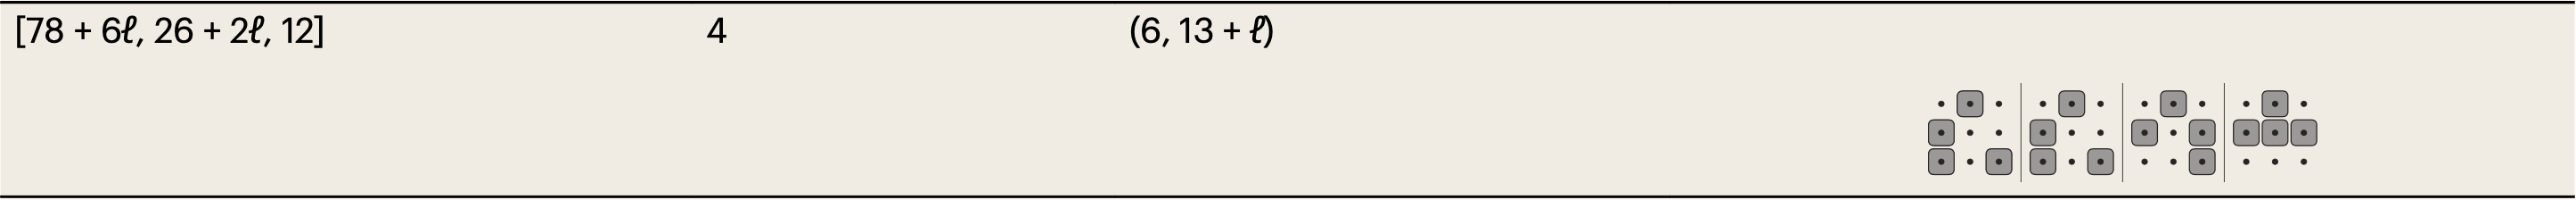

In [8]:
H, L = 6, 13
m = 3
stabilizer_shapes = [
    np.array([[0, 1, 0],
              [1, 0, 0],
              [1, 0, 1]]),
    np.array([[0, 1, 0],
              [1, 0, 0],
              [1, 0, 1]]),
    np.array([[0, 1, 0],
              [1, 0, 1],
              [0, 0, 1]]),
    np.array([[0, 1, 0],
              [1, 1, 1],
              [0, 0, 0]]),
    
]

print("Stabilizer shapes:")
print(stabilizer_shapes)
condition_indices_list = []

for shape in stabilizer_shapes:
    assert shape.shape == (3, 3), "Stabilizer shape must be 3x3."
    condition_indices_list.append(get_condition_indices(shape))

print(f"Condition indices extracted: {condition_indices_list}")

Z_basis = precompute_basis_outputs(H, L, m, condition_indices_list)

min_weight_inputs, min_weight_outputs, k, d, n, kd_over_n = find_distance_via_basis(Z_basis, H, L, m)
print(f"k: {k}, d: {d}, n: {n}, kd/n: {kd_over_n:.2f}")

Stabilizer shapes:
[array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 1]]), array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 1]]), array([[0, 1, 0],
       [1, 0, 1],
       [0, 0, 1]]), array([[0, 1, 0],
       [1, 1, 1],
       [0, 0, 0]])]
Condition indices extracted: [[(1, -1), (2, -1), (2, 1)], [(1, -1), (2, -1), (2, 1)], [(1, -1), (1, 1), (2, 1)], [(1, -1), (1, 0), (1, 1)]]
Found Z with d=15: 
[[1 1 1 1 0 0 0 0 0 1 0 1 0]
 [0 0 1 0 0 0 0 0 0 0 1 1 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]
kd/n = 5.00 with input: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]
Found Z with d=13: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]]
kd/n = 4.33 with input: 
[[0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1]]
Found Z with d=12: 
[[0 0 1 0 0 0 0 0 0 0 1 1 0]
 [1 1 0 0

In [9]:
for i, (input_row, Z) in enumerate(zip(min_weight_inputs, min_weight_outputs)):
    print(f"Input {i}: \n{input_row}")
    print(f"Z output {i}: \n{Z}")

Input 0: 
[[0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]
Z output 0: 
[[0 0 1 0 0 0 0 0 0 0 1 1 0]
 [1 1 0 0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]]
Input 1: 
[[0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1]]
Z output 1: 
[[0 0 0 0 0 0 0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1]]
Input 2: 
[[0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]]
Z output 2: 
[[0 1 0 0 0 0 0 0 0 1 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]]
Input 3: 
[[0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0]]
Z output 3: 
[[0 0 0 0 0 0 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0]
 [

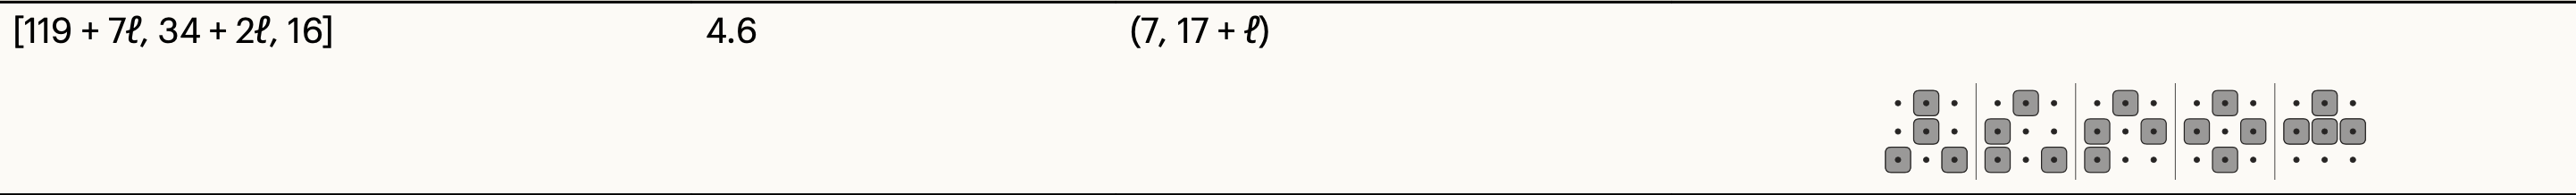

In [ ]:
H, L = 7, 17
m = 3
stabilizer_shapes = [
    np.array([[0, 1, 0],
              [0, 1, 0],
              [1, 0, 1]]),
    np.array([[0, 1, 0],
              [1, 0, 0],
              [1, 0, 1]]),
    np.array([[0, 1, 0],
              [1, 0, 1],
              [1, 0, 0]]),
    np.array([[0, 1, 0],
              [1, 0, 1],
              [0, 1, 0]]),
    np.array([[0, 1, 0],
              [1, 1, 1],
              [0, 0, 0]]),
    
]

print("Stabilizer shapes:")
print(stabilizer_shapes)
condition_indices_list = []

for shape in stabilizer_shapes:
    assert shape.shape == (3, 3), "Stabilizer shape must be 3x3."
    condition_indices_list.append(get_condition_indices(shape))

print(f"Condition indices extracted: {condition_indices_list}")

Z_basis = precompute_basis_outputs(H, L, m, condition_indices_list)

min_weight_inputs, min_weight_outputs, k, d, n, kd_over_n = find_distance_via_basis(Z_basis, H, L, m)
print(f"k: {k}, d: {d}, n: {n}, kd/n: {kd_over_n:.2f}")

Stabilizer shapes:
[array([[0, 1, 0],
       [0, 1, 0],
       [1, 0, 1]]), array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 1]]), array([[0, 1, 0],
       [1, 0, 1],
       [1, 0, 0]]), array([[0, 1, 0],
       [1, 0, 1],
       [0, 1, 0]]), array([[0, 1, 0],
       [1, 1, 1],
       [0, 0, 0]])]
Condition indices extracted: [[(1, 0), (2, -1), (2, 1)], [(1, -1), (2, -1), (2, 1)], [(1, -1), (1, 1), (2, -1)], [(1, -1), (1, 1), (2, 0)], [(1, -1), (1, 0), (1, 1)]]
Found Z with d=17: 
[[0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]
Found Z with d=17: 
[[1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0]
 [0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0

In [ ]:
for i, (input_row, Z) in enumerate(zip(min_weight_inputs, min_weight_outputs)):
    print(f"Input {i}: \n{input_row}")
    print(f"Z output {i}: \n{Z}")

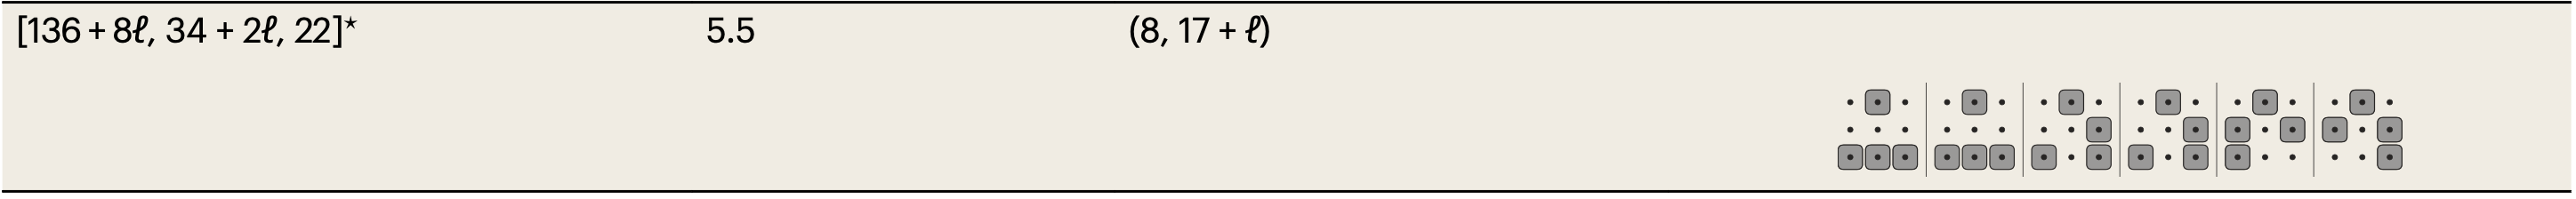

In [ ]:
H, L = 8, 17
m = 3
stabilizer_shapes = [
    np.array([[0, 1, 0],
              [0, 0, 0],
              [1, 1, 1]]),
    np.array([[0, 1, 0],
              [0, 0, 0],
              [1, 1, 1]]),
    np.array([[0, 1, 0],
              [0, 0, 1],
              [1, 0, 1]]),
    np.array([[0, 1, 0],
              [0, 0, 1],
              [1, 0, 1]]),
    np.array([[0, 1, 0],
              [1, 0, 1],
              [1, 0, 0]]),
    np.array([[0, 1, 0],
              [1, 0, 1],
              [0, 0, 1]]),
]

print("Stabilizer shapes:")
print(stabilizer_shapes)
condition_indices_list = []

for shape in stabilizer_shapes:
    assert shape.shape == (3, 3), "Stabilizer shape must be 3x3."
    condition_indices_list.append(get_condition_indices(shape))

print(f"Condition indices extracted: {condition_indices_list}")

Z_basis = precompute_basis_outputs(H, L, m, condition_indices_list)

min_weight_inputs, min_weight_outputs, k, d, n, kd_over_n = find_distance_via_basis(Z_basis, H, L, m)
print(f"k: {k}, d: {d}, n: {n}, kd/n: {kd_over_n:.2f}")